In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [131]:
v=0.25
lbg=0.1
k=0.0003
kbg=0.4
I0=300.0
mumax=1.2
rhomax=0.2
m=15.0
qmax=0.04
qmin=0.004
h=120.0
d=10.0
# Redfield ratio = 0.022 for q

zmax = 30.0
tmax = 10.0
dz = 1.0
dt = dz**2/40 # change this


In [132]:
# assuming homogeneous initial conditions over z
z_grid = np.arange(0,zmax,dz)
time_steps = np.arange(0,tmax,dt)

A_0 = np.ones(int(zmax/dz))*300
Rb_0 = np.ones(int(zmax/dz))*2.2
Rd_0 = np.ones(int(zmax/dz))*30
I_0 = np.ones(int(zmax/dz))*I0

# define results of matrices
# rows - deeper z-values, cols - time steps forward
A = np.zeros((int(zmax/dz),int(tmax/dt)))
Rb = np.zeros((int(zmax/dz),int(tmax/dt)))
Rd = np.zeros((int(zmax/dz),int(tmax/dt)))
I = np.zeros((int(zmax/dz),int(tmax/dt)))

A[:,0] = A_0
Rb[:,0] = Rb_0
Rd[:,0] = Rd_0
I[:,0] = I_0

A.shape

(30, 400)

In [133]:
time_steps.shape

(400,)

In [134]:
z_grid.shape

(30,)

In [135]:
def p(I,q):
    return mumax * (1.0 - qmin/q) * (I/(h + I))

def rho(q, Rd):
    return rhomax * (qmax-q)/(qmax-qmin) * ( Rd/(m + Rd) )

In [136]:
# check - dt must be much smaller than dz for stability (try to get exact expression later? ) 
dt/dz**2

0.025

In [137]:
def next_step(z,A,Rb,Rd,I):
    """For testing."""
    
    A_next = np.zeros(len(A))
    Rb_next = np.zeros(len(A))
    Rd_next =np.zeros(len(A))
    I_next = np.zeros(len(A))
    
    q = Rb[1:-1]/A[1:-1]
    pp = p(I[1:-1],q)
    rrho = rho(q,Rd[1:-1])
    
    A_next[1:-1] = dt*(d/(dz**2) - v/(2*dz))*A[2:] \
    + (1 + dt*pp - dt*lbg - 2*dt*d/(dz**2))*A[1:-1] \
    + dt*(d/(dz**2)- v/(2*dz))*A[:-2]
    A_next[0] = 4*d/(2*v*dz + 3*d)*A_next[1] - d/(2*v*dz + 3*d)*A_next[2]
    A_next[-1] = (4*A_next[-2] - A_next[-3])/3
    
    Rb_next[1:-1] = dt*(d/(dz**2) - v/(2*dz))*Rb[2:] \
    + (1 - dt*lbg - 2*dt*d/(dz**2))*Rb[1:-1] \
    + dt*(d/(dz**2) - v/(2*dz))*Rb[:-2] + dt*rrho*A[1:-1]
    Rb_next[0] = 4*d/(2*v*dz + 3*d)*Rb_next[1] - d/(2*v*dz + 3*d)*Rb_next[2]
    Rb_next[-1] = (4*Rb_next[-2] - Rb_next[-3])/3
    
    Rd_next[1:-1] = d*dt/(dz**2)*Rd[2:] \
    + (1 - 2*dt*d/(dz**2))*Rd[1:-1] \
    + d*dt/(dz**2)*Rd[:-2] \
    - dt*rrho*A[1:-1] + dt*lbg*Rb[1:-1]
    Rd_next[0] = 4*Rd[1]/3 - Rd[2]/3
    Rd_next[-1] = -Rd[-3]/3 + 4*Rd[-2]/3 - 2*v*dz*Rb[-1]/(3*d)
    
    I_next[1:] = -(dt*k*A[1:] + dt*kbg*z[1:] - 1)*I[1:]
    I_next[0] = I0
    
    return A_next, Rb_next, Rd_next, I_next

In [139]:
z_grid

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
       26., 27., 28., 29.])

In [140]:
i = 1
for t in time_steps[:-1]:
    A[:,i],Rb[:,i],Rd[:,i],I[:,i] = next_step(z_grid,A[:,i-1],Rb[:,i-1],Rd[:,i-1],I[:,i-1])
    i = i+1

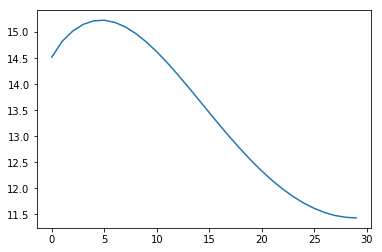

In [141]:
plt.plot(z_grid,A[:,-1])

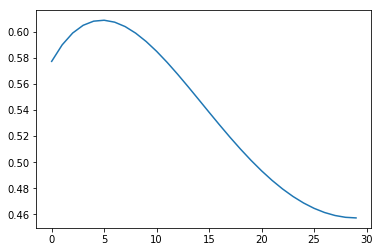

In [142]:
plt.plot(z_grid,Rb[:,-1])

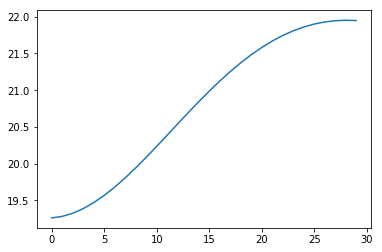

In [143]:
plt.plot(z_grid,Rd[:,-1])

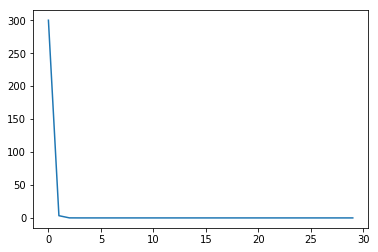

In [144]:
plt.plot(z_grid,I[:,-1])